# Downstream Analysis

Taking a look at the genes inferred using machine learning. Here are the folllowing genes of interest (blood-detectable according to the Human Protein Atlas): <br>
* PAEP
* PENK
* CXCL8
* TACSTD2
* MMP7
* KRT23
* TFP12
* IGHA1
* PLA2G2
* OGN
* KRT17
* TPSAB1
* CXCL12
* IGHG2

In [16]:
import anndata as ad
import scanpy as sc
import scvi

In [55]:
# Load anndata
adata= ad.read_h5ad("/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/processed/v3_integrated/anndata_integrated.h5ad")

In [56]:
adata

AnnData object with n_obs × n_vars = 93551 × 1176
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'samples', 'target', '_scvi_batch', '_scvi_labels'
    var: 'mt'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'

In [ ]:
# Integrate across samples and datasets as the merged datasets are not fully integrated
# Setup model, fit, and normalise train dataset 
scvi.model.SCVI.setup_anndata(adata, layer="counts", 
                              categorical_covariate_keys= ["sample", "dataset"], # choosing datasets as a covariate
                              continuous_covariate_keys= ["pct_counts_mt", "total_counts"])
# Fit on train set only
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train(accelerator="gpu") 


/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been set to `mps`. Please note that not all PyTorch/Jax operations are supported with this backend. as a result, some models might be slower and less accurate than usuall. Please verify your analysis!Refer to https://github.com/pytorch/pytorch/issues/77764 for more details.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 86/86: 100%|██████████| 86/86 [24:23<00:00, 15.66s/it, v_num=1, train_loss_step=261, train_loss_epoch=250]

`Trainer.fit` stopped: `max_epochs=86` reached.


Epoch 86/86: 100%|██████████| 86/86 [24:23<00:00, 17.02s/it, v_num=1, train_loss_step=261, train_loss_epoch=250]


In [ ]:
# Get normalized counts for train set
norm = model.get_normalized_expression(
    adata, 
    library_size=1e4,
    return_numpy=False
)
adata.layers["scVI_normalized"] = norm

# Insert latent representation
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

In [83]:
adata

AnnData object with n_obs × n_vars = 93551 × 1176
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'samples', 'target', '_scvi_batch', '_scvi_labels'
    var: 'mt'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scVI_normalized'

In [ ]:
# Normalize and log-transform the scVI layer
sc.pp.normalize_total(adata, target_sum=1e4, layer="scVI_normalized")
sc.pp.log1p(adata, layer="scVI_normalized")

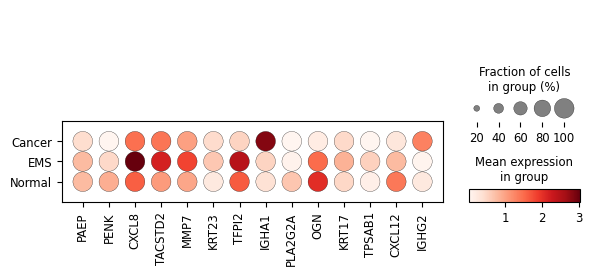

In [ ]:
# Dot-plotting
sc.pl.dotplot(
    adata,
    ["PAEP", "PENK", "CXCL8", "TACSTD2", "MMP7", "KRT23", "TFPI2",
    "IGHA1", "PLA2G2A", "OGN", "KRT17", "TPSAB1", "CXCL12", "IGHG2"],  # marker genes
    groupby="target", 
    layer="scVI_normalized",
    log=False,
    dendrogram=False
)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: FutureWarning: `scale` is deprecated, use `density_norm` instead
  return fn(*args_all, **kw)


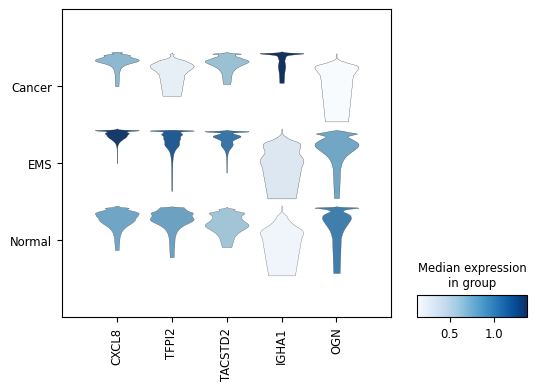

In [ ]:
# Violin plot
sc.pl.stacked_violin(adata,
    ["CXCL8", "TFPI2","TACSTD2", "IGHA1", "OGN"],
    groupby="target", 
    layer="scVI_normalized",
    log= True, jitter= False, size=0,
    scale="width",
    figsize=(6, 4))

This presents the panel of proteins nominated to the stakeholder (according to the fictional project.)